Kaggleの[Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)のデータです。

トレーニングデータを使用して、テストデータの脳梗塞の罹患を予測。

## データ概要

1. id：個人id
2. gender：性別
3. age：年齢
4. hypertension：高血圧ならば1、そうでなければ0
5. heart_disease：心臓病ならば1、そうでなければ0
6. ever_married：既婚
7. work_type：職業
8. Residence_type：居住区
9. avg_glucose_level：血液中のグルコース濃度
10. bmi：bmi値
11. smoking_status：喫煙ステータス
12. stroke：脳梗塞ならば1、そうでなければ0

分析の前に脳梗塞という病気について調べた

〇脳梗塞とは脳の血管が突然つまって血流が途絶え、脳の細胞が死んでしまう病気

・血管が細い

・動脈硬化→動脈硬化によってプラークと呼ばれる異常な組織が血管内に形成されるため、それがはがれて血栓となる場合がある

・血中のコレステロール値や中性脂肪値の異常によって血栓ができやすい環境になる

→食生活が乱れている人、肥満体形の人、運動する習慣のない人がなりやすい病気だと思われる


今回の分析の流れは以下の通りになっている

1．データの読み込み

2．言語データの数字化

3．欠損値の補充/削除

4．トレーニングデータをトレーニングデータとバリデーションデータに分割

5．脳梗塞罹患者のデータ、非脳梗塞患者のデータそれぞれの説明変数の平均値を比較

6．ロジスティック回帰分析・分類精度評価

7．決定木分析・分類精度評価

8．ランダムフォレスト・分類精度評価

9．submit.csvファイルの作成

今回工夫した点・苦労した点

・データの前処理に挑戦するのが初めてで、とても難しかったです。

　特にカテゴリデータを数値化したり、欠損値をデータに合わせて補完したりするのに苦労しました。

今後の課題

・KNNモデルを用いた欠損値の補完

　
smoke_statusのUnknownを補完する際にKNNモデルを使用しましたが、予測のために使用した説明変数の裏付けが弱くなってしまいました。
  
  　もっとよい手立てがあったのではないかと思うので他の方のコードをkaggleでチェックして参考にしたいと思います。
 
・最適なモデルの選択

　今回はロジスティック回帰分析、決定木、ランダムフォレストを用いて分類を行いました。
 
　しかしモデルの選択をする際に、予測値の内脳梗塞患者の割合が極端に少ないモデルばかりになってしまいました。
 　
  
  　結果として脳梗塞患者の割合という尺度だけですら、ちゃんとした予測になっているのがランダムフォレストを用いたものだけになってしまいました。
  
  　もっといろんな分析手法を勉強して自分の手札を増やしていきたいです。

In [325]:
#基本モジュールのインポート
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import collections
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [210]:
!pip install plotly
import plotly.express as px

In [211]:
!pip install numexpr

In [338]:
#トレーニングデータの読み込み
df_train = pd.read_csv("train.csv")
df_train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,45961,Female,78.0,0,0,Yes,Private,Urban,79.94,26.7,never smoked,0
1,8203,Male,17.0,0,0,No,Private,Rural,106.56,21.0,Unknown,0
2,51963,Male,58.0,0,0,Yes,Private,Urban,69.24,27.6,never smoked,0
3,36793,Female,38.0,1,0,Yes,Private,Rural,60.13,39.6,never smoked,0
4,23850,Male,66.0,0,0,Yes,Private,Urban,103.01,33.1,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4083,19601,Female,19.0,0,0,No,Private,Urban,100.60,20.5,never smoked,0
4084,27757,Male,31.0,0,0,Yes,Private,Urban,88.78,35.8,smokes,0
4085,53195,Male,30.0,0,0,No,Private,Urban,141.80,31.9,never smoked,0
4086,6319,Female,79.0,0,0,Yes,Private,Urban,97.93,31.2,Unknown,0


In [339]:
#テストデータの読み込み
df_test = pd.read_csv("test-checkpoint.csv")
df_test

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,72823,Female,79.0,0,0,Yes,Private,Urban,70.35,23.0,formerly smoked
1,50723,Male,47.0,0,0,Yes,Private,Rural,131.19,28.3,smokes
2,57308,Male,20.0,0,0,No,Private,Urban,78.97,19.4,never smoked
3,49666,Male,47.0,0,0,Yes,Self-employed,Urban,85.68,39.6,never smoked
4,34764,Female,33.0,0,0,Yes,Private,Rural,80.82,40.3,never smoked
...,...,...,...,...,...,...,...,...,...,...,...
977,14918,Female,41.0,0,0,Yes,Private,Urban,65.67,26.7,smokes
978,44628,Female,38.0,0,0,Yes,Private,Rural,91.09,22.2,never smoked
979,14489,Female,74.0,0,0,No,Self-employed,Urban,89.52,39.2,Unknown
980,10870,Male,51.0,0,0,Yes,Private,Rural,232.64,45.2,never smoked


カテゴリデータのうち、

・gender

・ever_married

・Residence_type

はそれぞれ２つしかカテゴリがないので0と1で表すことができる。


In [340]:
df_train['gender'] = df_train['gender'].map({'Female':0, 'Male':1})
df_train['ever_married'] = df_train['ever_married'].map({'Yes':0, 'No':1})
df_train['Residence_type'] = df_train['Residence_type'].map({'Rural':0, 'Urban':1})
df_train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,45961,0.0,78.0,0,0,0,Private,1,79.94,26.7,never smoked,0
1,8203,1.0,17.0,0,0,1,Private,0,106.56,21.0,Unknown,0
2,51963,1.0,58.0,0,0,0,Private,1,69.24,27.6,never smoked,0
3,36793,0.0,38.0,1,0,0,Private,0,60.13,39.6,never smoked,0
4,23850,1.0,66.0,0,0,0,Private,1,103.01,33.1,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4083,19601,0.0,19.0,0,0,1,Private,1,100.60,20.5,never smoked,0
4084,27757,1.0,31.0,0,0,0,Private,1,88.78,35.8,smokes,0
4085,53195,1.0,30.0,0,0,1,Private,1,141.80,31.9,never smoked,0
4086,6319,0.0,79.0,0,0,0,Private,1,97.93,31.2,Unknown,0


・work_type

「Private」「Govt_job」「Self-employed」「children」の4つのカテゴリがある

→それぞれに順序がないので0，1，2，3，4と番号を振ることができない

→ダミー変数化

・smoking_status

「never smoked」「Unknown」「foremerly smoked」「smokes」の4つのカテゴリが存在する

→「never smoked」「foremerly smoked」「smokes」には喫煙の度合いによる順序があり、0，1，2とそれぞれ数字を振っても問題ない。

→しかし、「Unknown」のカテゴリは欠損値なので他の列の欠損値とまとめて処理し、その後にsmoking_statusの文字データを数値化する

In [341]:
#replace関数によってUnknownをnanに変換
df_train.replace('Unknown',np.nan,inplace=True)
df_train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,45961,0.0,78.0,0,0,0,Private,1,79.94,26.7,never smoked,0
1,8203,1.0,17.0,0,0,1,Private,0,106.56,21.0,NaN,0
2,51963,1.0,58.0,0,0,0,Private,1,69.24,27.6,never smoked,0
3,36793,0.0,38.0,1,0,0,Private,0,60.13,39.6,never smoked,0
4,23850,1.0,66.0,0,0,0,Private,1,103.01,33.1,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4083,19601,0.0,19.0,0,0,1,Private,1,100.60,20.5,never smoked,0
4084,27757,1.0,31.0,0,0,0,Private,1,88.78,35.8,smokes,0
4085,53195,1.0,30.0,0,0,1,Private,1,141.80,31.9,never smoked,0
4086,6319,0.0,79.0,0,0,0,Private,1,97.93,31.2,NaN,0


In [342]:
#トレーニングデータの欠損値の確認

df_train.isnull().sum()

id                      0
gender                  1
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   164
smoking_status       1247
stroke                  0
dtype: int64

In [343]:
#欠損していないデータの抽出
train = df_train.dropna(subset=['smoking_status'],inplace = False)
train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,45961,0.0,78.0,0,0,0,Private,1,79.94,26.7,never smoked,0
2,51963,1.0,58.0,0,0,0,Private,1,69.24,27.6,never smoked,0
3,36793,0.0,38.0,1,0,0,Private,0,60.13,39.6,never smoked,0
4,23850,1.0,66.0,0,0,0,Private,1,103.01,33.1,never smoked,0
6,10133,1.0,46.0,0,0,0,Private,1,85.35,32.1,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4082,56185,0.0,28.0,0,0,1,Private,1,73.20,26.5,smokes,0
4083,19601,0.0,19.0,0,0,1,Private,1,100.60,20.5,never smoked,0
4084,27757,1.0,31.0,0,0,0,Private,1,88.78,35.8,smokes,0
4085,53195,1.0,30.0,0,0,1,Private,1,141.80,31.9,never smoked,0


In [344]:
#欠損しているデータの抽出
test = df_train \
  .loc[df_train.index.difference(train.index),:]
test

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,8203,1.0,17.0,0,0,1,Private,0,106.56,21.0,NaN,0
5,64597,0.0,33.0,0,0,0,Private,0,73.20,28.9,NaN,0
7,20351,1.0,75.0,0,0,0,Govt_job,1,94.29,35.2,NaN,0
14,28367,0.0,7.0,0,0,1,children,0,69.47,18.9,NaN,0
17,50965,1.0,53.0,0,0,1,Private,0,65.24,28.9,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4067,51109,0.0,6.0,0,0,1,children,0,119.88,17.8,NaN,0
4068,28913,1.0,78.0,0,0,0,Private,0,100.09,30.5,NaN,0
4072,14178,0.0,48.0,0,0,0,Private,0,195.16,42.2,NaN,0
4081,9995,1.0,8.0,0,0,1,children,1,118.66,16.1,NaN,0


In [345]:
#knnモデル学習
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train[['age','hypertension','heart_disease','ever_married']],train['smoking_status'])

KNeighborsClassifier(n_neighbors=3)

In [346]:
#knnモデルを用いて計算した予測値をsmoking_statusに代入
test['smoking_status'] = kn.predict(test[['age','hypertension','heart_disease','ever_married']])
test

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,8203,1.0,17.0,0,0,1,Private,0,106.56,21.0,never smoked,0
5,64597,0.0,33.0,0,0,0,Private,0,73.20,28.9,smokes,0
7,20351,1.0,75.0,0,0,0,Govt_job,1,94.29,35.2,formerly smoked,0
14,28367,0.0,7.0,0,0,1,children,0,69.47,18.9,never smoked,0
17,50965,1.0,53.0,0,0,1,Private,0,65.24,28.9,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4067,51109,0.0,6.0,0,0,1,children,0,119.88,17.8,never smoked,0
4068,28913,1.0,78.0,0,0,0,Private,0,100.09,30.5,never smoked,0
4072,14178,0.0,48.0,0,0,0,Private,0,195.16,42.2,never smoked,0
4081,9995,1.0,8.0,0,0,1,children,1,118.66,16.1,never smoked,0


In [347]:
#trainと欠損値に予測値を代入したtestを結合して新しいトレーニングデータフレームのdf_concatを作成
df_concat = pd.concat([train, test])
df_concat

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,45961,0.0,78.0,0,0,0,Private,1,79.94,26.7,never smoked,0
2,51963,1.0,58.0,0,0,0,Private,1,69.24,27.6,never smoked,0
3,36793,0.0,38.0,1,0,0,Private,0,60.13,39.6,never smoked,0
4,23850,1.0,66.0,0,0,0,Private,1,103.01,33.1,never smoked,0
6,10133,1.0,46.0,0,0,0,Private,1,85.35,32.1,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4067,51109,0.0,6.0,0,0,1,children,0,119.88,17.8,never smoked,0
4068,28913,1.0,78.0,0,0,0,Private,0,100.09,30.5,never smoked,0
4072,14178,0.0,48.0,0,0,0,Private,0,195.16,42.2,never smoked,0
4081,9995,1.0,8.0,0,0,1,children,1,118.66,16.1,never smoked,0


In [348]:
#smoking_statusのカテゴリデータを数値化
df_concat['smoking_status'] = df_concat['smoking_status'].map({'never smoked':0,'formerly smoked':1,'smokes':2})
df_concat

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,45961,0.0,78.0,0,0,0,Private,1,79.94,26.7,0,0
2,51963,1.0,58.0,0,0,0,Private,1,69.24,27.6,0,0
3,36793,0.0,38.0,1,0,0,Private,0,60.13,39.6,0,0
4,23850,1.0,66.0,0,0,0,Private,1,103.01,33.1,0,0
6,10133,1.0,46.0,0,0,0,Private,1,85.35,32.1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4067,51109,0.0,6.0,0,0,1,children,0,119.88,17.8,0,0
4068,28913,1.0,78.0,0,0,0,Private,0,100.09,30.5,0,0
4072,14178,0.0,48.0,0,0,0,Private,0,195.16,42.2,0,0
4081,9995,1.0,8.0,0,0,1,children,1,118.66,16.1,0,0


In [349]:
#gender,bmi値の欠損を平均値補完
df_concat = df_concat.fillna(df_train.mean())
df_concat

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,45961,0.0,78.0,0,0,0,Private,1,79.94,26.7,0,0
2,51963,1.0,58.0,0,0,0,Private,1,69.24,27.6,0,0
3,36793,0.0,38.0,1,0,0,Private,0,60.13,39.6,0,0
4,23850,1.0,66.0,0,0,0,Private,1,103.01,33.1,0,0
6,10133,1.0,46.0,0,0,0,Private,1,85.35,32.1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4067,51109,0.0,6.0,0,0,1,children,0,119.88,17.8,0,0
4068,28913,1.0,78.0,0,0,0,Private,0,100.09,30.5,0,0
4072,14178,0.0,48.0,0,0,0,Private,0,195.16,42.2,0,0
4081,9995,1.0,8.0,0,0,1,children,1,118.66,16.1,0,0


In [350]:
#欠損値を再確認
df_concat.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [351]:
#work_typeのダミー変数化
df_concat = pd.get_dummies(df_concat)
df_concat

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,45961,0.0,78.0,0,0,0,1,79.94,26.7,0,0,0,0,1,0,0
2,51963,1.0,58.0,0,0,0,1,69.24,27.6,0,0,0,0,1,0,0
3,36793,0.0,38.0,1,0,0,0,60.13,39.6,0,0,0,0,1,0,0
4,23850,1.0,66.0,0,0,0,1,103.01,33.1,0,0,0,0,1,0,0
6,10133,1.0,46.0,0,0,0,1,85.35,32.1,2,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,51109,0.0,6.0,0,0,1,0,119.88,17.8,0,0,0,0,0,0,1
4068,28913,1.0,78.0,0,0,0,0,100.09,30.5,0,0,0,0,1,0,0
4072,14178,0.0,48.0,0,0,0,0,195.16,42.2,0,0,0,0,1,0,0
4081,9995,1.0,8.0,0,0,1,1,118.66,16.1,0,0,0,0,0,0,1


In [352]:
#トレーニングデータをトレーニングデータとバリデーションデータに分割
df_concat_train, df_concat_valid = train_test_split(df_concat,test_size=0.3,train_size=0.7)
df_concat_train

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
188,67963,0.0,62.0,1,0,1,0,77.04,33.8,1,0,0,0,1,0,0
3395,67880,1.0,5.0,0,0,1,1,148.52,20.6,0,0,0,0,0,0,1
787,30693,0.0,22.0,0,0,1,1,68.40,37.5,0,0,0,0,1,0,0
3886,68596,0.0,19.0,0,0,1,1,58.39,28.2,0,0,0,0,1,0,0
1704,55457,0.0,48.0,0,0,0,1,110.18,30.3,2,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446,16550,0.0,69.0,0,1,1,1,202.38,34.6,1,0,1,0,0,0,0
1700,6988,0.0,52.0,0,0,0,1,113.21,38.3,0,0,0,0,0,1,0
1502,32183,0.0,67.0,0,0,0,0,66.08,36.2,0,0,0,0,1,0,0
1355,62471,0.0,34.0,0,0,0,0,68.53,29.7,0,0,0,0,0,1,0


テストデータにもトレーニングデータにしたものと全く同じ前処理を行います

In [353]:
#テストデータのカテゴリデータも数値化
df_test['gender'] = df_test['gender'].map({'Female':0, 'Male':1})
df_test['ever_married'] =df_test['ever_married'].map({'Yes':0, 'No':1})
df_test['Residence_type'] = df_test['Residence_type'].map({'Rural':0, 'Urban':1})
#Unknownには数値を割り当てないことでNaN表示になるように
df_test['smoking_status'] = df_test['smoking_status'].map({'never smoked':0,'formerly smoked':1,'smokes':2})

In [354]:
#テストデータの欠損値の確認
df_test.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status       290
dtype: int64

In [355]:
#smoking_statusの欠損値補完
train2 = df_test.dropna(subset=['smoking_status'],inplace = False)
test2 = df_test \
  .loc[df_test.index.difference(train2.index),:]
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train2[['age','hypertension','heart_disease','ever_married']],train2['smoking_status'])
test2['smoking_status'] = kn.predict(test2[['age','hypertension','heart_disease','ever_married']])
df_concat2 = pd.concat([train2, test2])
df_concat2

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,72823,0,79.0,0,0,0,Private,1,70.35,23.0,1.0
1,50723,1,47.0,0,0,0,Private,0,131.19,28.3,2.0
2,57308,1,20.0,0,0,1,Private,1,78.97,19.4,0.0
3,49666,1,47.0,0,0,0,Self-employed,1,85.68,39.6,0.0
4,34764,0,33.0,0,0,0,Private,0,80.82,40.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...
960,6104,0,7.0,0,0,1,children,0,85.15,15.1,0.0
966,4929,1,8.0,0,0,1,children,1,78.48,16.1,0.0
967,33167,0,59.0,0,0,0,Private,1,89.96,28.1,0.0
970,46891,0,74.0,0,0,0,Private,0,68.34,39.3,0.0


In [356]:
#ダミー変数化
df_concat2 = pd.get_dummies(df_concat2)
df_concat2

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,72823,0,79.0,0,0,0,1,70.35,23.0,1.0,0,0,1,0,0
1,50723,1,47.0,0,0,0,0,131.19,28.3,2.0,0,0,1,0,0
2,57308,1,20.0,0,0,1,1,78.97,19.4,0.0,0,0,1,0,0
3,49666,1,47.0,0,0,0,1,85.68,39.6,0.0,0,0,0,1,0
4,34764,0,33.0,0,0,0,0,80.82,40.3,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,6104,0,7.0,0,0,1,0,85.15,15.1,0.0,0,0,0,0,1
966,4929,1,8.0,0,0,1,1,78.48,16.1,0.0,0,0,0,0,1
967,33167,0,59.0,0,0,0,1,89.96,28.1,0.0,0,0,1,0,0
970,46891,0,74.0,0,0,0,0,68.34,39.3,0.0,0,0,1,0,0


In [477]:
#脳梗塞患者のデータだけ抽出
df = df_concat.query('stroke == 1')
#非脳梗塞患者のデータを抽出
df2 = df_concat.query('stroke == 0')

In [359]:
#脳梗塞患者のみのデータの各説明変数の平均値
df.mean()

id                         38295.222772
gender                         0.420792
age                           67.521386
hypertension                   0.282178
heart_disease                  0.193069
ever_married                   0.123762
Residence_type                 0.534653
avg_glucose_level            132.586040
bmi                           30.240560
smoking_status                 0.737624
stroke                         1.000000
work_type_Govt_job             0.128713
work_type_Never_worked         0.000000
work_type_Private              0.608911
work_type_Self-employed        0.252475
work_type_children             0.009901
dtype: float64

In [360]:
#脳梗塞ではない人のデータの各説明変数の平均値
df2.mean()

id                         35975.451879
gender                         0.405920
age                           41.645373
hypertension                   0.091096
heart_disease                  0.047092
ever_married                   0.359238
Residence_type                 0.507463
avg_glucose_level            105.193178
bmi                           28.844578
smoking_status                 0.570252
stroke                         0.000000
work_type_Govt_job             0.129182
work_type_Never_worked         0.004889
work_type_Private              0.568708
work_type_Self-employed        0.152856
work_type_children             0.144364
dtype: float64

まず、脳梗塞患者が全体の約5％（202/4088）

この数値をこれから先の予測モデルの評価において参考にする

→極端に脳梗塞患者の数が少ない・多いモデルは採用しない。

脳梗塞患者と非脳梗塞患者のそれぞれの説明変数の平均値を比較すると...

有意な差があると考えられる説明変数は↓

['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','work_type_children']

これらの説明変数を用いてこれから分類モデルの作成を行う

In [448]:
#ロジスティック回帰分析用のモジュールのインポート
from sklearn.linear_model import LogisticRegression
#説明変数と目的変数の指定
X_train = df_concat_train[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','work_type_children']]
y_train = df_concat_train[['stroke']]

X_valid =df_concat_valid[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','work_type_children']]
y_valid = df_concat_valid[['stroke']]

X_test = df_concat2[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','work_type_children']]
#ロジスティック回帰分析によるモデルの作成
lr = LogisticRegression(C=100.0,random_state=1,solver='lbfgs',multi_class='ovr')

lr.fit(X_train,y_train)

C:\Users\ryu_s\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ryu_s\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=100.0, multi_class='ovr', random_state=1)

In [474]:
#分類精度の正確さを測るモジュールのインポート
from sklearn.metrics import accuracy_score
#代入する引数を定義
y_true=y_valid
y_pred = lr.predict(X_valid)
y_pred
#ロジスティック回帰分析モデルの精度評価
accuracy_score(y_true, y_pred,normalize=True, sample_weight=None)

0.9511002444987775

In [452]:
#ロジスティック回帰分析モデルを用いたテストデータの予測値
lr.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

予測値が0しかない。実質予測していないのと変わらない。

In [475]:
#決定木のライブラリ・モジュールのインポート
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
#説明変数と目的変数の指定
X_train = df_concat_train[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','work_type_children']]
y_train = df_concat_train[['stroke']]
#決定木を用いたモデルの作成
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4,random_state=1)

tree_model.fit(X_train,y_train)

accuracy_score(y_true, tree_model.predict(X_valid),normalize=True, sample_weight=None)

0.9494702526487367

In [453]:
#分類木の可視化に必要なライブラリ
!pip install graphviz
!pip install pydotplus

In [455]:
#分類木の可視化に必要なモジュールのインポート
from IPython.display import Image
from graphviz import Digraph
from pydotplus import pydotplus
from sklearn import tree

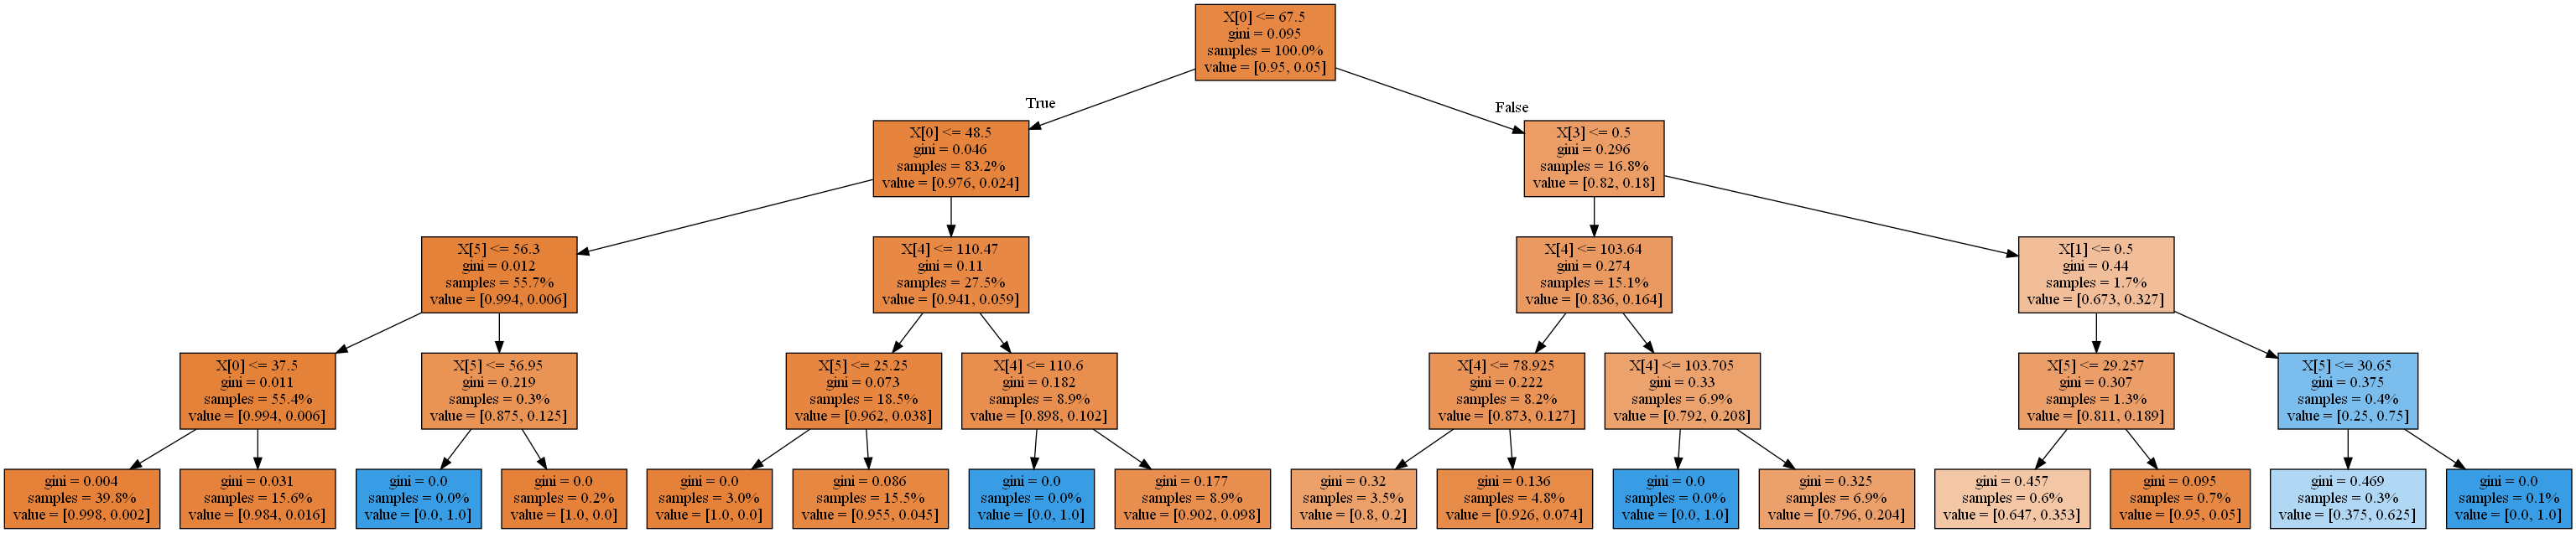

In [456]:
#分類木を可視化
dot_data = tree.export_graphviz(
    tree_model,
    out_file=None,
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [430]:
#分類木を用いたモデルによるテストデータの予測値の可視化
tree_model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

トレーニングデータの5%と比べると極端に予測されている脳梗塞患者が少ない

In [463]:
# ランダムフォレストによる分類のモジュールをインポート
from sklearn.ensemble import RandomForestClassifier as RFC
#説明変数と目的変数の指定
X_train = df_concat_train[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','work_type_children']]
y_train = df_concat_train[['stroke']]
#モデルの作成
rfc = RFC(n_estimators=100)
rfc.fit(X_train, y_train)
#分類精度の評価
accuracy_score(y_true, rfc.predict(X_valid),normalize=True, sample_weight=None)

<ipython-input-463-2cdeb4d77fe7>:7: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9462102689486552

In [464]:
#ランダムフォレストモデルによる予測の可視化
rfc.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

・バリデーションデータを用いた検証に基づくロジスティック回帰分析、決定木によるモデルの予測精度と同程度の予測精度であること

・トレーニングデータにおける脳梗塞患者の割合に大分近づいたこと

→ランダムフォレストを用いた分類モデルを今回は採用

In [471]:
#arrayをデータフレーム化
df_predict = pd.DataFrame(rfc.predict(X_test),columns=['stroke_or_not'])
#脳梗塞患者の数
print(df_predict.value_counts())

stroke_or_not
0                958
1                 24
dtype: int64


In [472]:
#テストデータと予測データを結合
df_output = pd.concat([df_test,df_predict],axis=1)
df_output

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke_or_not
0,72823,0,79.0,0,0,0,Private,1,70.35,23.0,1.0,0
1,50723,1,47.0,0,0,0,Private,0,131.19,28.3,2.0,0
2,57308,1,20.0,0,0,1,Private,1,78.97,19.4,0.0,0
3,49666,1,47.0,0,0,0,Self-employed,1,85.68,39.6,0.0,0
4,34764,0,33.0,0,0,0,Private,0,80.82,40.3,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
977,14918,0,41.0,0,0,0,Private,1,65.67,26.7,2.0,0
978,44628,0,38.0,0,0,0,Private,0,91.09,22.2,0.0,0
979,14489,0,74.0,0,0,1,Self-employed,1,89.52,39.2,NaN,0
980,10870,1,51.0,0,0,0,Private,0,232.64,45.2,0.0,0


In [473]:
# submission.csvをカレントディレクトリに書き込む
# Write result.csv to the current directory
df_output.to_csv('submit.csv', index=False)